In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ipywidgets as widgets
from IPython.display import display

Initializing SIR_model and Gillespie's Algorithm functions

In [5]:
# Deterministic SIR model
def SIR_model(y, t, beta, gamma):
    S, I, R = y
    dS_dt = -beta * S * I / (S + I + R)
    dI_dt = beta * S * I / (S + I + R) - gamma * I
    dR_dt = gamma * I
    return [dS_dt, dI_dt, dR_dt]

def gillespie_algorithm(S0, I0, R0, beta, gamma, max_time):
    # Initial conditions
    S, I, R = S0, I0, R0
    t = 0
    times = [t]
    S_values = [S]
    I_values = [I]
    R_values = [R]

    while t < max_time and I > 0:
        N = S + I + R

        # Calculate propensities
        a1 = beta * S * I / N
        a2 = gamma * I
        a0 = a1 + a2

        # Time until next event
        dt = -np.log(np.random.random()) / a0
        t += dt

        # Determine which event occurs
        r = np.random.random()
        if r < a1 / a0:
            # Transmission event
            S -= 1
            I += 1
        else:
            # Recovery event
            I -= 1
            R += 1

        # Store results
        times.append(t)
        S_values.append(S)
        I_values.append(I)
        R_values.append(R)

    return times, S_values, I_values, R_values

We set the transmission rate to 0.3, recovery rate to 0.1. The initial number of susceptible and infected individuals can vary, the initial number of recovered individual is always 0.

interactive(children=(IntSlider(value=990, description='S0:', max=1000, step=10), IntSlider(value=10, descript…

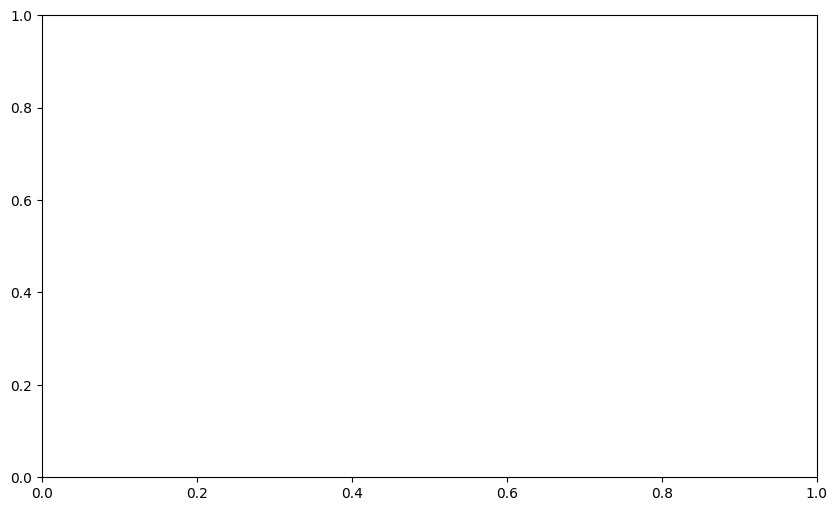

In [6]:
# Parameters
beta = 0.3
gamma = 0.1
max_time = 200
t = np.linspace(0, max_time, 1000)

def update_plot(S0, I0):
    R0 = 0
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Solve ODE for deterministic SIR
    solution = odeint(SIR_model, [S0, I0, R0], t, args=(beta, gamma))
    S_det, I_det, R_det = solution.T

    # Run Gillespie algorithm multiple times
    num_runs = 100
    all_S = []
    all_I = []
    all_R = []

    for _ in range(num_runs):
        times, S_values, I_values, R_values = gillespie_algorithm(S0, I0, R0, beta, gamma, max_time)
        all_S.append(np.interp(t, times, S_values))
        all_I.append(np.interp(t, times, I_values))
        all_R.append(np.interp(t, times, R_values))

    # Compute average and standard deviation
    avg_S = np.mean(all_S, axis=0)
    std_S = np.std(all_S, axis=0)
    avg_I = np.mean(all_I, axis=0)
    std_I = np.std(all_I, axis=0)

    # Plotting

    # Deterministic SIR
    ax.plot(t, S_det, label="Susceptible (Deterministic)", linestyle="--")
    ax.plot(t, I_det, label="Infectious (Deterministic)", linestyle="--")

    # Average Stochastic SIR
    ax.plot(t, avg_S, label="Avg Susceptible (Stochastic)")
    ax.fill_between(t, avg_S - std_S, avg_S + std_S, alpha=0.2)
    ax.plot(t, avg_I, label="Avg Infectious (Stochastic)")
    ax.fill_between(t, avg_I - std_I, avg_I + std_I, alpha=0.2)

    ax.set_xlabel("Time")
    ax.set_ylabel("Population")
    ax.set_title(f"Comparison of Deterministic and Stochastic SIR Models ({num_runs} runs)")
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

S0_slider = widgets.IntSlider(value=990, min=0, max=1000, step=10, description='S0:')
I0_slider = widgets.IntSlider(value=10, min=0, max=100, step=10, description='I0:')
widgets.interactive(update_plot, S0=S0_slider, I0=I0_slider)